In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)
    moving_averages = []

    for i in range(start_index, end_index + 1):
        start = max(0, i - window_size)
        end = min(data_length, i + window_size + 1)
        window = data[start:end]
        valid_values = [value for value in window if not pd.isna(value)]
        if len(valid_values) > 0:
            moving_averages.append(np.mean(valid_values))
        else:
            moving_averages.append(np.nan)

    modified_data = data.copy()
    modified_data[start_index:end_index + 1] = moving_averages
    modified_column = pd.Series(modified_data, name=column.name)

    return modified_column

In [5]:
# Linear Interpolation 
def ends_filler(column):
    if  column.dtype.kind in ['i', 'f']:
            column = first_filler(column)
            column = last_filler(column)
    return column

def first_filler(column):
    if pd.isnull(column.at[0]) or np.isnan(column.at[0]):
        size = len(column) -1
        first_valid_index = 0
        while first_valid_index <= size and (pd.isnull(column.at[first_valid_index]) or np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > size:
            column.at[0] = 0.0
        else:
            column.at[0] = column.at[first_valid_index]
    return column
    
def last_filler(column):
    if pd.isnull(column.at[len(column) -1]) or np.isnan(column.at[len(column) -1]):  
        last_valid_index = len(column) -1
        while last_valid_index >= 0 and (pd.isnull(column.at[last_valid_index]) or np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < 0:
            column.at[len(column) -1] = 0.0
        else:
            column.at[len(column) -1] = column.at[last_valid_index]
    return column
    
def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def linear_filler(column):
    if column.isnull().any():
        for i, value in enumerate(column):
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                linear_a = (column.at[end] - column.at[start])/(end - start)
                linear_b = column.at[start] - linear_a*start
                for x in gap:
                    column.at[x] = linear_a*x + linear_b
    return column 


In [6]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = ends_filler(df[col])
                df[col] = linear_filler(df[col]) 
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
            i += 1
        return df

In [10]:
df = read_csv_replace_missing_by_polynomial('nfsp_fluxo_mensal_corrente.csv', 0, 0)
df_porcentagem = read_csv_replace_missing_by_polynomial('nfsp_porcentagem_pib.csv', 0, 0)
df['NFSP - Porcentagem do PIB (%)'] = df_porcentagem.iloc[:, 1]
df

,data,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%)
0,1999,-2686.815600,6.244800
1,1999,-2646.894615,6.270769
2,1999,-2723.980741,6.345185
3,1999,-2885.953929,6.396071
4,1999,-2957.072069,6.466552
...,...,...,...
287,2022,-20875.113103,3.231837
288,2023,-23383.170000,3.374490
289,2023,-21958.728519,3.514286
290,2023,-22958.999231,3.634082


In [12]:
df_ano = df.groupby('data').mean()
df_ano = df_ano.rename_axis('Ano', axis='index')
df_ano

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%)
Ano,,
1999,-2855.381439,6.723507
2000,-3044.854323,8.802763
2001,-3552.593588,11.640272
2002,-4384.524218,12.279864
2003,-5555.144405,11.015510
2004,-6641.313248,8.258333
2005,-7501.427279,4.246922
2006,-8464.638690,2.722279
2007,-8131.585663,2.850527


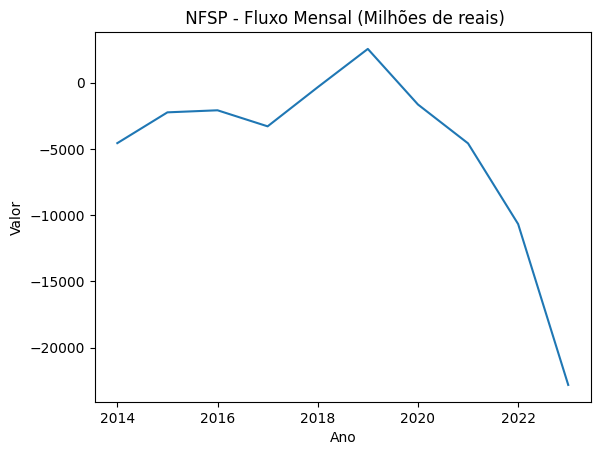

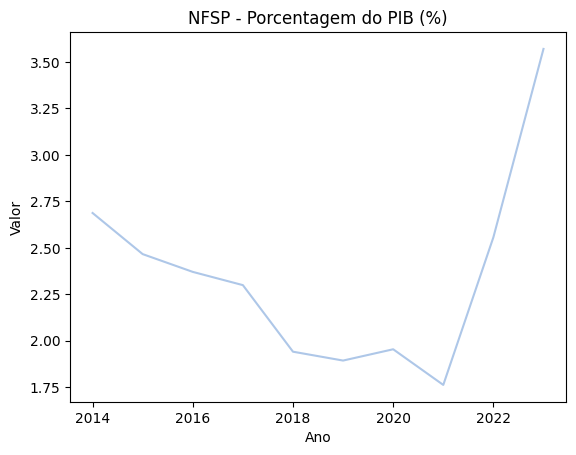

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%)
Ano,,
2014,-4566.408895,2.687568
2015,-2243.507585,2.466241
2016,-2088.581088,2.370595
2017,-3299.111854,2.299337
2018,-347.069558,1.941054
2019,2540.575697,1.893333
2020,-1649.748095,1.954116
2021,-4582.677827,1.762228
2022,-10669.409418,2.556684


In [13]:
df_2014 = df_ano[df_ano.index >= 2014]
plot_columns(df_2014)
df_2014

In [14]:
df_2014.to_csv("2014_01_nfsp.csv", index=True)